In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from link_queue_model import *
from plot_density import *
from IMM_filter import *
from estimation_quality_eval import *
import random

random.seed(2024)

In [2]:
def observability_score_by_mode(A_list, C, mode_list):
    observable_component_num_list = []
    for mode in range(len(A_list)):
        A = A_list[mode]
        observable_component_num = np.sum((C@matrix_power(A, 5)).sum(axis = 0)>0)
        observable_component_num_list.append(observable_component_num)
    return observable_component_num_list

In [3]:
def check_occurrence(A, u, A_list, A_dict, u_list, u_dict, mode_list, mode_transition_num):
    '''
    Record distinct A, u, and record the occurrence for mode frequency tracking purpose
    '''
    check_flag = 0
    j = 0
    for j in range(len(A_list)):
        A_ = A_list[j]
        if np.all(A_ == A):
            check_flag = 1
            break
    if check_flag == 0:
        A_list.append(A)
        u_list.append(u)
        A_dict[len(A_list)-1] = 1
        u_dict[len(u_list)-1] = 1
    else:
        A_dict[j] += 1
        u_dict[j] += 1
    # Find the index of A in A_list
    mode = next(i for i, x in enumerate(A_list) if np.array_equal(x, A))
    mode_list.append(mode)
    if mode >= mode_transition_num.shape[0]:
        # Add a new row of zeros
        new_row = np.zeros((1, mode_transition_num.shape[1]))
        mode_transition_num = np.append(mode_transition_num, new_row, axis=0)

        # Add a new column of zeros
        new_column = np.zeros((mode_transition_num.shape[0], 1))
        mode_transition_num = np.append(mode_transition_num, new_column, axis=1)
    
    if len(mode_list) > 1: 
        mode_transition_num[mode_list[-2], mode] += 1
    return A_list, A_dict, u_list, u_dict, mode_list, mode_transition_num

In [4]:
def LQM_matrix_sumo(network_geometry, link_list, alpha_merge =0.5, split_ratio=0.6):
    
    def get_ordinary(A, u, l):
        '''
        From the supply and demand, compute the system update equation (matrix)
        x_(k+1) = A x_k + u_k
        Compute A and u_k
        l: indices of the 2 ordinary links ex. [1, 2]
        '''
        l1 = l[0]; l2 = l[1]
        link_1 = link_list[l1]
        link_2 = link_list[l2]  
        d1,s1 = link_1.demand_supply_values()
        d2,s2 = link_2.demand_supply_values()
        g1 = min(d1, s2)
        if g1 == d1:
            # demand of link1 is less than supply of link2
            if d1<link_1.C/3600:
                # demand of link1 is less than capacity (v*k)
                A[l1][l1] += -link_1.FD.vf/3600
                A[l2][l1] += link_1.FD.vf/3600
            else:
                # f2 = g1 = C
                u[l1, 0] += -link_1.C/3600
                u[l2, 0] += link_1.C/3600
        elif s2 < link_2.C/3600:
            A[l2][l2] += -link_2.FD.w /3600
            A[l1][l2] += link_2.FD.w/3600
            u[l1, 0] += -link_2.FD.w * link_2.FD.kj / 3600
            u[l2, 0] += link_2.FD.w * link_2.FD.kj / 3600     
        else:
            u[l1, 0] = u[l1, 0] -link_2.C/3600
            u[l2, 0] += link_2.C/3600
        return A, u


    def get_merge(A, u, l, alpha_merge = 0.5):
        '''
        From the supply and demand, compute the system update equation (matrix)
        x_(k+1) = A x_k + u_k
        Compute A and u_k
        l: indices of the merging junction links ex. [link1_id, link2_id, link3_id] >-  
        alpha_merge: merging priority, fair merge (0.5) by default
        '''
        l1 = l[0]; l2 = l[1]; l3 = l[2]
        link_1 = link_list[l1]
        link_2 = link_list[l2]
        link_3 = link_list[l3]
        
        d1,s1 = link_1.demand_supply_values()
        d2,s2 = link_2.demand_supply_values()
        d3,s3 = link_3.demand_supply_values()
        f3 = min(d1+d2, s3)
        g1 = min(d1, max(s3-d2, alpha_merge *s3))
        g2 = min(d2, max(s3-d1, (1-alpha_merge) *s3))
        
        # if 1
        if f3 == d1+d2:  # demand is less than supply   
            # if 2
            if d1<link_1.C/3600:  # d1 = k1 v1 (will not involve u)
                A[l3][l1] += link_1.FD.vf/3600
                A[l1][l1] += -link_1.FD.vf/3600
            else: 
                # d1 = C1, need to update u 
                u[l1, 0] += -link_1.C/3600
                u[l3, 0] += link_1.C/3600
            if d2<link_2.C/3600: 
                A[l3][l2] += link_2.FD.vf/3600
                A[l2][l2] += -link_2.FD.vf/3600
            else:
                # d2 = C2, need to update u
                u[l2, 0] += -link_2.C/3600
                u[l3, 0] += link_2.C/3600
        else:  # d1+d2>s3
            # if 1
            if s3<link_3.C/3600:
                # s3 = w3*(kj - k3)
                A[l3][l3] += -link_3.FD.w/3600
                u[l3, 0] += link_3.FD.w*link_3.FD.kj/3600
                
                # if 2
                if g1 == d1:  
                    if d1<link_1.C/3600: # g1=k1*v1, g2=s3-d1
                        A[l2][l1] += link_1.FD.vf/3600
                        A[l1][l1] += -link_1.FD.vf/3600
                        A[l2][l3] += link_3.FD.w/3600
                        u[l2, 0] += -link_3.FD.w * link_3.FD.kj /3600
                    else:   #g1 = C1, g2 = s3-C1
                        u[l1, 0] += -link_1.C/3600
                        u[l2, 0] += link_1.C/3600 - link_3.FD.w*link_3.FD.kj/3600
                        A[l2][l3] += link_3.FD.w/3600
                        
                elif g2 == d2:  
                    if d2<link_2.C/3600: # g2=k2*v2, g1=s3-d2
                        A[l1][l2] += link_2.FD.vf/3600
                        A[l2][l2] += -link_2.FD.vf/3600
                        A[l1][l3] += link_3.FD.w/3600
                        u[l1, 0] += -link_3.FD.w * link_3.FD.kj /3600
                    else:   #g1 = C1, g2 = s3-C1
                        u[l2, 0] += -link_2.C/3600
                        u[l1, 0] += link_2.C/3600 - link_3.FD.w*link_3.FD.kj/3600
                        A[l1][l3] += link_3.FD.w/3600    
                
                else:  # g1=g2=1/2 s3 for fair merge
                    A[l1][l3] += alpha_merge * link_3.FD.w/3600
                    A[l2][l3] += (1-alpha_merge)*link_3.FD.w/3600
                    u[l1, 0] += -alpha_merge * link_3.FD.w * link_3.FD.kj / 3600
                    u[l2, 0] += -(1-alpha_merge) * link_3.FD.w * link_3.FD.kj / 3600    

            else: 
                # s3>=link_3.C/3600
                u[l3, 0] += link_3.C/3600
                
                if g1 == d1:  
                    if d1<link_1.C/3600: # g1=k1*v1, g2=s3-d1
                        A[l2][l1] += link_1.FD.vf/3600
                        A[l1][l1] += -link_1.FD.vf/3600
                        u[l2, 0] += -link_3.C/3600
                    else:   #g1 = C1, g2 = s3-C1
                        u[l1, 0] += -link_1.C/3600
                        u[l2, 0] += link_1.C/3600 - link_3.C/3600
                        
                elif g2 == d2:  
                    if d2<link_2.C/3600: # g2=k2*v2, g1=s3-d2
                        A[l1][l2] += link_2.FD.vf/3600
                        A[l2][l2] += -link_2.FD.vf/3600
                        u[l1, 0] += -link_3.C/3600
                    else:   #g1 = C1, g2 = s3-C1
                        u[l2, 0] += -link_2.C/3600
                        u[l1, 0] += link_2.C/3600 -  link_3.C/3600
                
                else:  # g1=g2=1/2 s3 for fair merge
                    u[l1, 0] += -alpha_merge *  link_3.C / 3600
                    u[l2, 0] += -(1-alpha_merge) *  link_3.C / 3600 
                
        return A, u      


    def get_diverge(A,u, l, r=0.5):
        # r is the split ratio from link1 to link2, 0.5: 50% of vehicles travel to link2 from link1
        l1 = l[0]; l2 = l[1]; l3 = l[2]; r12 = r; r13 = 1-r
        link_1 = link_list[l1]
        link_2 = link_list[l2]
        link_3 = link_list[l3]
        d1,s1 = link_1.demand_supply_values()
        d2,s2 = link_2.demand_supply_values()
        d3,s3 = link_3.demand_supply_values()
        g1 = min(d1, s2/r12, s3/r13)
        f2 = r12*g1
        f3 = r13*g1
        
        if g1 == d1:  #all flow can get to downstreams
            if d1<link_1.C/3600:
                A[l1][l1] += -link_1.FD.vf /3600
                A[l2][l1] += link_1.FD.vf * r12 /3600
                A[l3][l1] += link_1.FD.vf * r13 /3600
            else:
                u[l1, 0] += -link_1.C/3600
                u[l2, 0] += link_1.C*r12/3600
                u[l3, 0] += link_1.C*r13/3600
        elif g1 == s2/r12:  #link2 is the bottleneck
            if s2<link_2.C/3600:
                A[l1][l2] += 1/r12 * link_2.FD.w /3600; u[l1, 0] += -1/r12 * link_2.FD.w * link_2.FD.kj  /3600
                A[l2][l2] += -link_2.FD.w/3600;  u[l2, 0] += link_2.FD.w * link_2.FD.kj  /3600
                A[l3][l2] += -r13/r12*link_2.FD.w/3600; u[l3, 0] +=r13/r12 * link_2.FD.w * link_2.FD.kj  /3600
            else:
                u[l1, 0] += -1/r12 * link_2.C/3600
                u[l2, 0] += link_2.C/3600
                u[l3, 0] += r13/r12*link_2.C/3600
                
        else: #link3 is the bottleneck
            if s3<link_3.C/3600:
                A[l1][l3] += 1/r13 * link_3.FD.w /3600; u[l1, 0] += -1/r13 * link_3.FD.w * link_3.FD.kj /3600
                A[l3][l3] += -link_3.FD.w/3600;  u[l3, 0] += link_3.FD.w * link_3.FD.kj  /3600
                A[l2][l3] += -r12/r13*link_3.FD.w/3600; u[l2, 0] +=r13/r12 * link_3.FD.w * link_3.FD.kj /3600
            else: 
                u[l1, 0] += -1/r13 * link_3.C/3600
                u[l2, 0] += link_3.C/3600
                u[l3, 0] += r12/r13*link_3.C/3600
        return A, u


    '''
    boundary_flow: np.array (dim = n) a vector of n dimensions with non-zero elements at the boundary locations
                  defines the flow (veh/s) at each boundary link
    network_geometry: list of list of list, defines the network geometry including ordinary, merge and diverge junctions
                    ex. network >--< [[[3,4]], [[1,2,3]], [[4,5,6]]]
    '''
    
    density_list = list(); boundary_list = list()
    A_list = list(); u_list = list()
    A_dict = {}; u_dict = {}
    mode_list = list()
    mode_transition_num = np.zeros((1, 1)).astype(int)
    
    for i in range(len(density_list_sumo)):
        
        link_list[0].k = density_list_sumo[i][0] 
        link_list[1].k = density_list_sumo[i][1] 
        link_list[2].k = density_list_sumo[i][2] 
        link_list[3].k = density_list_sumo[i][3] 
        link_list[4].k = density_list_sumo[i][4] 
        link_list[5].k = density_list_sumo[i][5]
        
        
        link_density = np.array([link_list[i].k for i in range(n)]).reshape(n, 1)
                # compute boundary flow 
        if i < len(density_list_sumo)-1:
            boundary_flow = compute_boundary_flow(i, inflow_list, outflow_list, link_list)
        boundary_flow = boundary_flow/length
        boundary_list.append(boundary_flow) 
        
        # update mode matrix 
        A = np.eye(n)
        # update the Bu term 
        u = np.zeros((n,1))
        # compute noise      
        
        # update the matrix elements based on all junction types
        for ordinary_junction_index in network_geometry[0]:
            A, u = get_ordinary(A, u, ordinary_junction_index)  
            
        for merge_junction_index in network_geometry[1]:
            A, u = get_merge(A, u, merge_junction_index, alpha_merge)  
        
        for diverge_junction_index in network_geometry[2]:
            A, u = get_diverge(A, u, diverge_junction_index, split_ratio)  
        
        A = (A - np.eye(n))/length + np.eye(n)
        u = u/length
        
        A_list, A_dict, u_list, u_dict, mode_list, mode_transition_num = check_occurrence(A, u, A_list, A_dict, u_list, u_dict, mode_list, mode_transition_num)
    return A_list, u_list, mode_transition_num, mode_list, boundary_list, A_dict

In [5]:
#open text file in read mode
text_file = open("D:/2023 Spring/research/SUMO/6link_ISTTT_SUMO/inflow1.xml", "r")
data = text_file.read()
text_file.close()
text_file = open("D:/2023 Spring/research/SUMO/6link_ISTTT_SUMO/inflow2.xml", "r")
data2 = text_file.read()
text_file.close()
text_file = open("D:/2023 Spring/research/SUMO/6link_ISTTT_SUMO/outflow1.xml", "r")
data3 = text_file.read()
text_file.close()
text_file = open("D:/2023 Spring/research/SUMO/6link_ISTTT_SUMO/outflow2.xml", "r")
data4 = text_file.read()
text_file.close()

t = 0
inflow1_list = list(); inflow2_list = list(); outflow3_list = list(); outflow4_list = list()
dt = 1
while t<=8000:
    s1 = 'begin="'+str(t)+'.00" end="'+str(t+dt)+'.00"'
    s2 = 'begin="'+str(t+dt)+'.00" end="'+str(t+2*dt)+'.00"'
    t += dt
    substring = data[data.find(s1):data.find(s2)]
    substring2 = data2[data2.find(s1):data2.find(s2)]
    substring3 = data3[data3.find(s1):data3.find(s2)]
    substring4 = data4[data4.find(s1):data4.find(s2)]
    
    try:
        inflow1 = float(substring[substring.find('nVehContrib="')+13:substring.find('" flow=')])
        inflow2 = float(substring2[substring2.find('nVehContrib="')+13:substring2.find('" flow=')])
        outflow3 = float(substring3[substring3.find('nVehContrib="')+13:substring3.find('" flow=')])
        outflow4 = float(substring4[substring4.find('nVehContrib="')+13:substring4.find('" flow=')])
            
        inflow1_list.append(inflow1)
        inflow2_list.append(inflow2)
        outflow3_list.append(outflow3)
        outflow4_list.append(outflow4)
    except ValueError:
        break
        
T = t-1
    

In [6]:
# plot simulated result
#open text file in read mode
filenames = ["e1_0.xml","e1_1.xml","e1_2.xml","e1_3.xml","e1_4.xml","e1_5.xml"]
occ_sumo = []; spd_sumo = [] 
for filename in filenames:
    text_file = open("D:/2023 Spring/research/SUMO/6link_ISTTT_SUMO/"+filename, "r")
    #read whole file to a string
    data = text_file.read()
    #close file
    text_file.close()

    t = 0
    f_list = []; occ_list = []; spd_list = []
    dt = 30
    while t<=T:
        s1 = 'begin="'+str(t)+'.00" end="'+str(t+dt)+'.00"'
        s2 = 'begin="'+str(t+dt)+'.00" end="'+str(t+2*dt)+'.00"'
        t += dt
        substring = data[data.find(s1):data.find(s2)]
        if substring != '':
            flow = float(substring[substring.find('flow="')+6:substring.find('" occu')])
            occ = float(substring[substring.find('occupancy="')+11:substring.find('" speed=')])
            spd = float(substring[substring.find('MeanSpeed="')+11:substring.find('" length=')])
        f_list.append(flow)
        occ_list.append(occ)
        spd_list.append(spd)
    occ_sumo.append(occ_list)
    spd_sumo.append(spd_list)

DELETE

In [7]:
import pandas as pd

def moving_average_with_ends(series, window):
    # Create a pandas Series
    s = pd.Series(series)

    # Calculate the moving average
    ma = s.rolling(window, min_periods=1, center=True).mean()

    # Keep the start and end values unchanged
    ma.iloc[0] = series[0]
    ma.iloc[-1] = series[-1]

    return list(ma)


In [7]:
k_occ = 2
density_list_expanded = []; density_list_sumo = []
window_size = 3
# occ_sumo[5] =  moving_average_with_ends(occ_sumo[5], window_size)
for occ_i in occ_sumo:
    density_i_expanded = []
    for i in range(len(occ_i)-1):
        density_i_expanded.extend(list(np.linspace(occ_i[i],occ_i[i+1], 31)[0:-1]*k_occ))
    density_list_expanded.append(density_i_expanded)
    
for i in range(len(density_list_expanded[0])):
    density_list_sumo.append(np.array((density_list_expanded[0][i],
                              density_list_expanded[1][i],
                              density_list_expanded[2][i],
                              density_list_expanded[3][i],
                              density_list_expanded[4][i],
                              density_list_expanded[5][i])).reshape(6,1))


#  compare LQM and SUMO

In [8]:
FD1 = fundamental_diagram(108, 18, 135)
FD2 = fundamental_diagram(72, 15, 140)

T = len(inflow1_list)
l = 0.2 #200 meters link length
dT = 1

density_list = list()
link1 = link(0, 0.2, FD1)
link2 = link(0, 0.2, FD2)
link3 = link(0, 0.2, FD1)
link4 = link(0, 0.2, FD1)
link5 = link(0, 0.2, FD1)
link6 = link(0, 0.2, FD2)
density_list.append((link1.k,link2.k,link3.k,link4.k,link5.k,link6.k))

for i in range(T):
    d1 = link1.FD.demand(link1.k) 
    s1 = link1.FD.supply(link1.k)
    d2 = link2.FD.demand(link2.k)
    s2 = link2.FD.supply(link2.k)
    d3 = link3.FD.demand(link3.k)
    s3 = link3.FD.supply(link3.k)
    d4 = link4.FD.demand(link4.k)
    s4 = link4.FD.supply(link4.k)
    d5 = link5.FD.demand(link5.k)
    s5 = link5.FD.supply(link5.k)
    d6 = link6.FD.demand(link6.k)
    s6 = link6.FD.supply(link6.k)


    f1 = inflow1_list[i]
    f2 = inflow2_list[i]
    g5 = outflow3_list[i]
    f3 = min(d1+d2, s3)
    g1 = min(d1, max(s3-d2, 1/2 *s3))
    g2 = f3-g1
    g3 = min(d3, s4)
    f4 = g3
    g4 = min(d4, s5/0.6, s6/0.4)
    f5 = 0.6*g4
    f6 = 0.4*g4
    g6 = d6
    #g6 = outflow4_list[i]
    
    link1.k = link1.k + (f1-g1)*dT/l
    link2.k = link2.k + (f2-g2)*dT/l
    link3.k = link3.k + (f3-g3)*dT/l
    link4.k = link4.k + (f4-g4)*dT/l
    
    link5.k = link5.k + (f5-g5)*dT/l
    #link5.k = max(link5.k, 0)
    link6.k = link6.k + (f6-g6)*dT/l
    density_list.append((link1.k,link2.k,link3.k,link4.k,link5.k,link6.k))
  
    
d1, d2, d3, d4, d5, d6 = list(zip(*density_list))

Text(0.5, 1.0, 'Link density evolution')

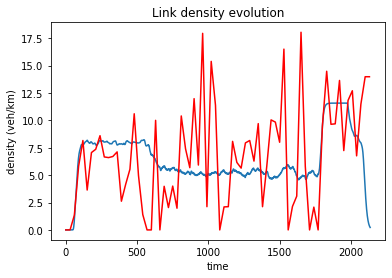

In [9]:
import matplotlib.pyplot as plt
plt.plot(d6)
time_list = np.arange(len(occ_sumo[5]))*30
plt.plot(time_list,np.array(occ_sumo[5])/100 * 200, color = "red")
plt.xlabel("time")
plt.ylabel("density (veh/km)")
plt.title("Link density evolution")

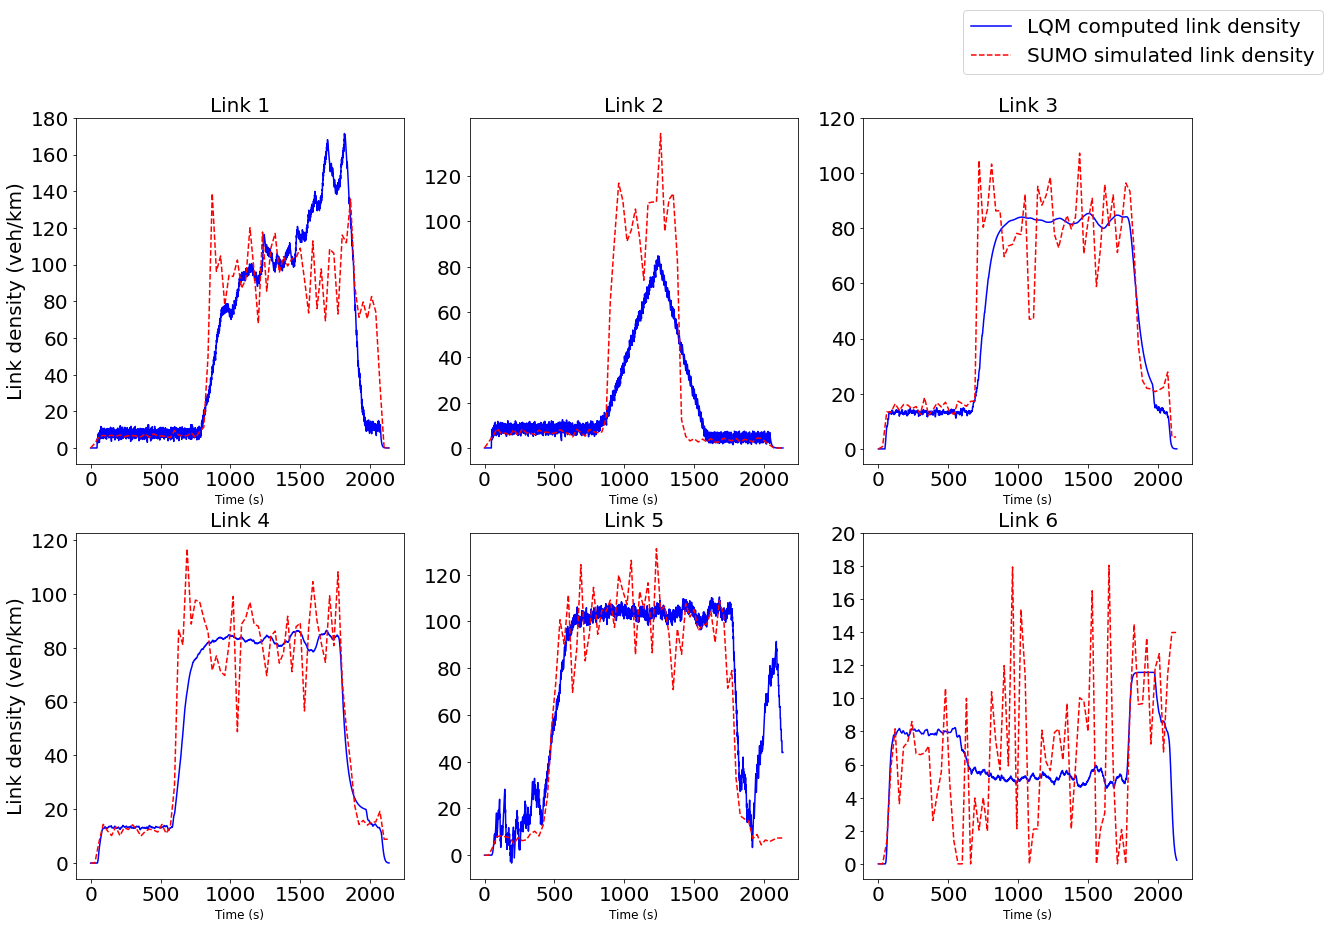

In [10]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 3,figsize=(20, 14))
k_occ = 2
# link1
s1,=axis[0, 0].plot(np.arange(len(d1)),d1, color = "blue")
s2,=axis[0, 0].plot(time_list,np.array(occ_sumo[0])*k_occ, color = "red",linestyle='dashed')
axis[0, 0].set_title("Link 1",fontsize = 20)
axis[0, 0].set_yticks(np.arange(0, 190, 20))
axis[0, 0].set_xlabel('Time (s)',fontsize = 12)

# link2
axis[0, 1].plot(d2, color = "blue")
axis[0, 1].plot(time_list,np.array(occ_sumo[1])*k_occ, color = "red",linestyle='dashed')
axis[0, 1].set_title("Link 2",fontsize = 20)
axis[0, 1].set_yticks(np.arange(0, 140, 20))
axis[0, 1].set_xlabel('Time (s)',fontsize = 12)

# link3
axis[0, 2].plot(d3, color = "blue")
axis[0, 2].plot(time_list,np.array(occ_sumo[2])*k_occ, color = "red",linestyle='dashed')
axis[0, 2].set_title("Link 3",fontsize = 20)
axis[0, 2].set_yticks(np.arange(0, 140, 20))
axis[0, 2].set_xlabel('Time (s)',fontsize = 12)

# link2
axis[1, 0].plot(d4, color = "blue")
axis[1, 0].plot(time_list,np.array(occ_sumo[3])*k_occ, color = "red",linestyle='dashed')
axis[1, 0].set_title("Link 4",fontsize = 20)
axis[1, 0].set_yticks(np.arange(0, 140, 20))
axis[1, 0].set_xlabel('Time (s)',fontsize = 12)

# link5
axis[1, 1].plot(d5, color = "blue")
axis[1, 1].plot(time_list,np.array(occ_sumo[4])*k_occ, color = "red",linestyle='dashed')
axis[1, 1].set_title("Link 5",fontsize = 20)
axis[1, 1].set_yticks(np.arange(0, 140, 20))
axis[1, 1].set_xlabel('Time (s)',fontsize = 12)


# link6
axis[1, 2].plot(d6, color = "blue")
axis[1, 2].plot(time_list,np.array(occ_sumo[5])*k_occ, color = "red",linestyle='dashed')
axis[1, 2].set_title("Link 6",fontsize = 20)
axis[1, 2].set_yticks(np.arange(0, 21, 2))
axis[1, 2].set_xlabel('Time (s)',fontsize = 12)


axis[0, 0].set_ylabel('Link density (veh/km)', fontsize = 20)
axis[1, 0].set_ylabel('Link density (veh/km)', fontsize = 20)

handles=[s1,s2]
figure.legend(handles, ["LQM computed link density",'SUMO simulated link density'], loc='upper right',fontsize = 20)


In [11]:
temp_sumo_density = density_list_sumo[100: 2050]
density_list_sumo = temp_sumo_density
T = len(density_list_sumo)


## Estimate white gaussian noise


In [12]:
T = len(density_list_sumo)
T

1950

In [13]:
err = []
for i in range(T-1):
    k1 = float(density_list_sumo[i][0])
    k2 = float(density_list_sumo[i][1])
    k3 = float(density_list_sumo[i][2])
    k4 = float(density_list_sumo[i][3])
    k5 = float(density_list_sumo[i][4])
    k6 = float(density_list_sumo[i][5])
    
    d1 = link1.FD.demand(k1)
    s1 = link1.FD.supply(k1)
    d2 = link2.FD.demand(k2)
    s2 = link2.FD.supply(k2)
    d3 = link3.FD.demand(k3)
    s3 = link3.FD.supply(k3)
    d4 = link4.FD.demand(k4)
    s4 = link4.FD.supply(k4)
    d5 = link5.FD.demand(k5)
    s5 = link5.FD.supply(k5)
    d6 = link6.FD.demand(k6)
    s6 = link6.FD.supply(k6)


    f1 = inflow1_list[i]
    f2 = inflow2_list[i]
    g5 = outflow3_list[i]
    f3 = min(d1+d2, s3)
    g1 = min(d1, max(s3-d2, 1/2 *s3))
    g2 = f3-g1
    g3 = min(d3, s4)
    f4 = g3
    g4 = min(d4, s5/0.6, s6/0.4)
    f5 = 0.6*g4
    f6 = 0.4*g4
    g5
    g6 = d6
    
    
    k1 = k1 + (f1-g1)*dT/l
    k2 = k2 + (f2-g2)*dT/l
    k3 = k3 + (f3-g3)*dT/l
    k4 = k4 + (f4-g4)*dT/l
    k5 = k5 + (f5-g5)*dT/l
    k5 = max(k5, 0)
    k6 = k6 + (f6-g6)*dT/l
    
    err.append([k1-density_list_sumo[i+1][0,0],
           k2-density_list_sumo[i+1][1,0],
           k3-density_list_sumo[i+1][2,0],
           k4-density_list_sumo[i+1][3,0],
           k5-density_list_sumo[i+1][4,0],
           k6-density_list_sumo[i+1][5,0]])

In [14]:
err = np.array(err)

In [15]:
mean = np.mean(err, axis=0)
cov = np.cov(err, rowvar=0)

In [16]:
mean

array([-0.09534825,  0.10126199, -0.12171154,  0.02460289,  0.07582664,
        0.00027177])

In [17]:
Q = cov

# IMM Filtering

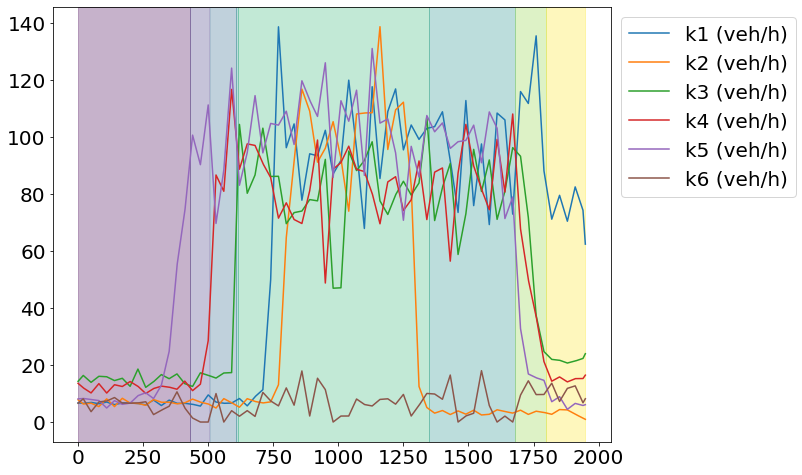

In [18]:
n = 6
# T = min(len(outflow3_list), len(boundary_list))
Q = cov
R = np.eye(n)*0
length=0.2

link1 = link(0, 0.2, FD1)
link2 = link(0, 0.2, FD2)
link3 = link(0, 0.2, FD1)
link4 = link(0, 0.2, FD1)
link5 = link(0, 0.2, FD1)
link6 = link(0, 0.2, FD2)


link_list = [link1,link2,link3,link4, link5, link6]


network_geometry = ([[2, 3]],[[0, 1, 2]],[[3,4,5]])
inflow_list = []; outflow_list = []
for i in range(T):      
    inflow_list.append([inflow1_list[i],inflow2_list[i],0,0,0,0])
    outflow_list.append([0,0,0,0,outflow3_list[i],outflow4_list[i]])


A_list, u_list, mode_transition_num, mode_list, boundary_list, A_dict = LQM_matrix_sumo(network_geometry, link_list)
# density_list, boundary_list2, A_list, u_list, mode_list, mode_transition_num, A_dict = LQM_matrix(inflow_list, outflow_list, network_geometry, link_list, WITH_NOISE = False, split_ratio=0.7)

plot_density(density_list_sumo, mode_list)

In [20]:

def compute_MSE(x_list, density_list):
    n = len(density_list[0])  # number of links
    Absolute_percentage_error = 0  
    # add up error for all time steps
    for i in range(len(x_list)):
        # err is a vector of estimation errors (with length n)
        err = np.array(x_list[i]) - np.array(density_list[i])
        Absolute_percentage_error += np.sum(err**2)
    MSE = Absolute_percentage_error/len(x_list)/n
    return MSE

In [23]:
len(A_list)

7

In [21]:
n = 6
sensor_loc = (0,1,2,3)
p = len(sensor_loc)
Q = cov
density_list = density_list[0:len(density_list_sumo)]
T = len(density_list_sumo)

zero_vector_n = np.zeros(n)
vect = np.zeros(n)
vect[np.array(sensor_loc)]  = 1
C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

y_k = list()
for i in range(T):
    y_k.append(C@density_list_sumo[i])

# A_list_active, u_list_active, mode_transition_num_active = active_mode(A_list1,A_dict1, u_list1, mode_list1, mode_transition_num1)
# PI = compute_PI(A_list_active, mode_transition_num_active)
# x_list, mu_list = IMM_filter_reduced(A_list_active, PI)


PI = compute_PI(A_list, mode_transition_num)
x_list, mu_list = IMM_filter(A_list, u_list, boundary_list, PI, C, Q, y_k)

compute_MSE(x_list, density_list_sumo)


249614.03298574846

In [38]:
u_list[6]

array([[-3.375     ],
       [ 0.        ],
       [ 0.48214286],
       [ 2.89285714],
       [ 0.        ],
       [ 0.        ]])

In [26]:
x_list[2000]

IndexError: list index out of range

NameError: name 'mode_list' is not defined

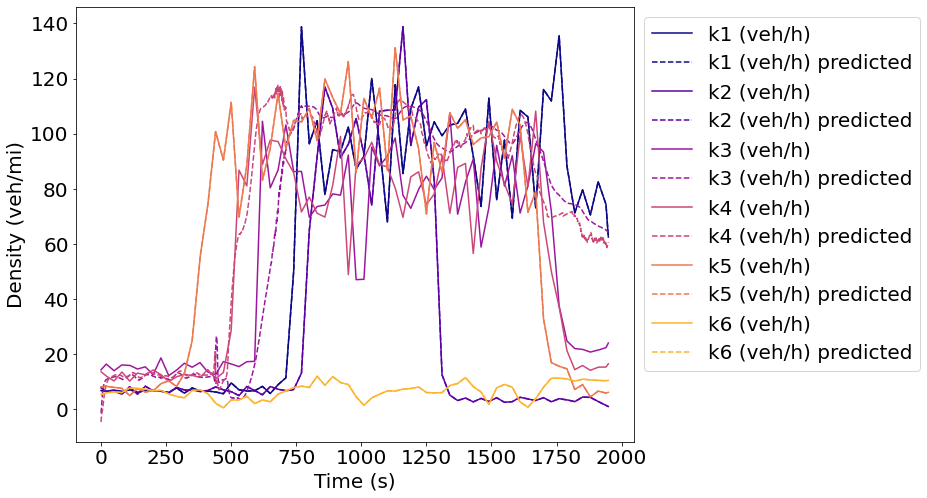

In [22]:
plot_2densities(density_list_sumo,x_list)

In [98]:
    
def compute_error(x_list, density_list):
    Absolute_percentage_error = 0
    for i in range(len(x_list)):
        err = np.array(x_list[i]) - np.array(density_list[i])
        Absolute_percentage_error += np.sum(abs(err)/np.array(density_list[i]))
    MAPE = Absolute_percentage_error/len(x_list)/n
    return MAPE


    
def compute_error_by_mode(x_list, density_list):
    MAPE_mode_i = np.zeros(len(A_list))
    for i in range(len(x_list)):
        mode_k = mode_list[i]
        err = np.array(x_list[i]) - np.array(density_list[i])
        MAPE_mode_i[mode_k] += np.sum(abs(err)/np.array(density_list[i]))
    for k in range(len(A_list)):
        mode_occurrence = np.sum(np.array(mode_list)==k)
        MAPE_mode_i[k] = MAPE_mode_i[k] / mode_occurrence/6
    return MAPE_mode_i

In [101]:
def plot_2densities(density_list, x_list, vect = None):
    import matplotlib.pyplot as plt
    plt.rc('font', size=20)
    T = len(density_list)
    t_list = list(range(T))
    
#     for j in range(n):
#         k_list = [i[j][0] for i in density_list]
#         plt.plot(t_list, k_list, label ="k" +str(j)+"(veh/mi)")
    
    # Create the plot

    fig, ax = plt.subplots(figsize=(10, 8)) 
    
    color_ind = 0
    for j in range(n):
        k1_list = [i[j][0] for i in density_list]   
        k2_list = [i[j][0] for i in x_list]   
        
        if vect is None:
            color = plt.cm.plasma(j / n)
            ax.plot(t_list, k1_list, label='k'+str(j+1)+" (veh/h)", linestyle='-', color=color)
            ax.plot(t_list, k2_list, label='k'+str(j+1)+" (veh/h) predicted", linestyle='--', color=color)
        elif vect[j]==0:
            color = plt.cm.plasma(color_ind / len(np.where(vect == 0)[0]))
            color_ind += 1
            ax.plot(t_list, k1_list, label='k'+str(j+1)+" (veh/h)", linestyle='-', color=color)
            ax.plot(t_list, k2_list, label='k'+str(j+1)+" (veh/h) predicted", linestyle='--', color=color)
            
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Density (veh/mi)')
    # Put the legend outside the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Define a colormap with different colors for each index
    cmap = plt.cm.get_cmap('viridis', max(mode_list)+1)
    
    start_index = 0
    for end_index in range(1, T):
        if mode_list[end_index]!=mode_list[start_index]:
            ax.axvspan(start_index, end_index-1, alpha=0.3, color=cmap(mode_list[start_index]))
            start_index = end_index
    ax.axvspan(start_index, end_index, alpha=0.3, color=cmap(mode_list[start_index]))         

    plt.show()

In [23]:
w = np.fromiter(A_dict.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))
from numpy.linalg import matrix_power
def observability_score(A_list, C, w):
    observable_component_num_list = []
    for temp_matrix in A_list:
        observable_component_num = np.sum((C@matrix_power(temp_matrix, 5)).sum(axis = 0)>0)
        observable_component_num_list.append(observable_component_num)
    return(sum(np.array(observable_component_num_list)*w))

In [24]:
from itertools import combinations

def find_combinations(n, k):
    # Generate all combinations of k elements from a sequence of n elements
    all_combinations = list(combinations(range(n), k))
    return all_combinations


In [30]:
len(boundary_list)

1950

In [32]:

n = 6
p = 4
all_comb = find_combinations(n, p)
w = np.fromiter(A_dict.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))
PI = compute_PI(A_list, mode_transition_num)

observability_list = []
MAPE_list = []
MAPE_by_mode_list = []
observability_by_mode_list = []


for sensor_loc in all_comb:   
    vect = np.zeros(n)
    vect[np.array(sensor_loc)]  = 1
    C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

    y_k = list()
    for i in range(T):
        y_k.append(C@density_list_sumo[i])

    x_list, mu_list = IMM_filter(A_list, u_list, boundary_list, PI, C, Q, y_k)
    
    print("---------------------------------------------------")
    MAPE = np.round(compute_error(x_list, density_list_sumo)*100, 4)
    MAPE_list.append(MAPE)
    obs_score = observability_score(A_list, C, w)
    observability_list.append(obs_score)
    
    
    # MAPE_by_mode = compute_error_by_mode(x_list, density_list_sumo)
    # MAPE_by_mode_list.append(list(MAPE_by_mode))
    # observability_score_by_mode(A_list, C, mode_list)
    # observability_by_mode_list.append(observability_score_by_mode(A_list, C, mode_list))
    
    print("observe", tuple(np.array(sensor_loc)+1), 'Error', observability_score(A_list, C, w), '| MAPE (%) = ', MAPE)
    

---------------------------------------------------
observe (1, 2, 3, 4) Error 4.6405128205128205 | MAPE (%) =  3069.7209
---------------------------------------------------
observe (1, 2, 3, 5) Error 4.961538461538462 | MAPE (%) =  2017.1686
---------------------------------------------------
observe (1, 2, 3, 6) Error 4.961538461538462 | MAPE (%) =  199.5687
---------------------------------------------------
observe (1, 2, 4, 5) Error 4.947692307692307 | MAPE (%) =  1701.6518
---------------------------------------------------
observe (1, 2, 4, 6) Error 5.588205128205127 | MAPE (%) =  72.8268
---------------------------------------------------
observe (1, 2, 5, 6) Error 5.818461538461539 | MAPE (%) =  16.0234
---------------------------------------------------
observe (1, 3, 4, 5) Error 4.624615384615385 | MAPE (%) =  2636.1558
---------------------------------------------------
observe (1, 3, 4, 6) Error 5.265128205128205 | MAPE (%) =  666.4958
-------------------------------------

The sensor location 

In [2454]:

n = 6
p = 5
all_comb = find_combinations(n, p)
w = np.fromiter(A_dict.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))
PI = compute_PI(A_list, mode_transition_num)

observability_list = []
MAPE_list = []
MAPE_by_mode_list = []
observability_by_mode_list = []


for sensor_loc in all_comb:   
    vect = np.zeros(n)
    vect[np.array(sensor_loc)]  = 1
    C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

    y_k = list()
    for i in range(T):
        y_k.append(C@density_list_sumo[i])

    x_list, mu_list = IMM_filter_reduced(A_list,PI)
    
    print("---------------------------------------------------")
    MAPE = np.round(compute_error(x_list, density_list_sumo)*100, 4)
    MAPE_list.append(MAPE)
    obs_score = observability_score(A_list, C, w)
    observability_list.append(obs_score)
    
    
    MAPE_by_mode = compute_error_by_mode(x_list, density_list_sumo)
    MAPE_by_mode_list.append(list(MAPE_by_mode))
    observability_score_by_mode(A_list, C, mode_list)
    observability_by_mode_list.append(observability_score_by_mode(A_list, C, mode_list))
    
    print("observe", tuple(np.array(sensor_loc)+1), 'Error', observability_score(A_list, C, w), '| MAPE (%) = ', MAPE)
    

---------------------------------------------------
observe (1, 2, 3, 4, 5) Error 5.0 | MAPE (%) =  600.6764
---------------------------------------------------
observe (1, 2, 3, 4, 6) Error 5.64051282051282 | MAPE (%) =  60.3297
---------------------------------------------------
observe (1, 2, 3, 5, 6) Error 5.961538461538461 | MAPE (%) =  12.878
---------------------------------------------------
observe (1, 2, 4, 5, 6) Error 5.947692307692306 | MAPE (%) =  11.1459
---------------------------------------------------
observe (1, 3, 4, 5, 6) Error 5.624615384615384 | MAPE (%) =  45.5159
---------------------------------------------------
observe (2, 3, 4, 5, 6) Error 5.311282051282051 | MAPE (%) =  416.9018


In [ ]:
obs_num_list = observability_score_mode(A_list, C, mode_list)

In [ ]:
plot_2densities_mode( density_list_sumo[:2849],x_list[:2849], obs_num_list, vect)

In [596]:
def plot_2densities_mode(density_list, x_list, mode_list, vect = None):
    import matplotlib.pyplot as plt
    plt.rc('font', size=30)
    T = len(density_list)
    t_list = list(range(T))
    
#     for j in range(n):
#         k_list = [i[j][0] for i in density_list]
#         plt.plot(t_list, k_list, label ="k" +str(j)+"(veh/mi)")
    
    # Create the plot
   
    fig, ax = plt.subplots(figsize=(20, 12)) 
    
    color_ind = 0
    for j in range(n):
        k1_list = [i[j][0] for i in density_list]   
        k2_list = [i[j][0] for i in x_list]   
        
        if vect is None:
            color = plt.cm.plasma(j / n)
            ax.plot(t_list, k1_list, label='k'+str(j+1)+" (veh/h)", linestyle='-', color=color)
            ax.plot(t_list, k2_list, label='k'+str(j+1)+" (veh/h) predicted", linestyle='--', color=color)
        elif vect[j]==0:
            color = plt.cm.plasma(color_ind / len(np.where(vect == 0)[0]))
            color_ind += 1
            ax.plot(t_list, k1_list, label='k'+str(j+1)+" (veh/h)", linestyle='-', color=color)
            ax.plot(t_list, k2_list, label='k'+str(j+1)+" (veh/h) predicted", linestyle='--', color=color)
            
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Density (veh/mi)')
    # Put the legend outside the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Define a colormap with different colors for each index
    cmap = plt.cm.RdYlGn
    
    for i in range(1,T):
        ax.axvspan(i-1, i, alpha=0.1, color=cmap(mode_list[i]))         

    plt.show()

In [74]:
def plot_2densities_mode(density_list, x_list, mode_list, vect = None):
    import matplotlib.pyplot as plt
    plt.rc('font', size=30)
    T = len(density_list)
    t_list = list(range(T))
    
#     for j in range(n):
#         k_list = [i[j][0] for i in density_list]
#         plt.plot(t_list, k_list, label ="k" +str(j)+"(veh/mi)")
    
    # Create the plot
   
    fig, ax = plt.subplots(figsize=(20, 12)) 
    
    color_ind = 0
    color_list = ['cyan','green','blue','purple','orange','blue']
    for j in range(n):
        k1_list = [i[j][0] for i in density_list]   
        k2_list = [i[j][0] for i in x_list]   
        
        
        if vect is None:
            color = color_list[j]
            ax.plot(t_list, k1_list, label='link '+str(j+1)+" actual", linestyle='-', color=color, linewidth = 2.5)
            ax.plot(t_list, k2_list, label='link '+str(j+1)+" estimated", linestyle='--', color=color, linewidth = 2.5)
        elif vect[j]==0:
            color = color_list[j]
            color_ind += 1
            ax.plot(t_list, k1_list, label='link '+str(j+1)+" actual", linestyle='-', color=color, linewidth = 2.5)
            ax.plot(t_list, k2_list, label='link '+str(j+1)+" estimated", linestyle='--', color=color, linewidth = 2.5)
            
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Density (veh/km)')
    # Put the legend outside the plot

    # Define a colormap with different colors for each index
    cmap = plt.cm.RdYlGn
    
    
    ax.axvspan(0, 430, alpha=0.2, color="red", label = "link 5,6 not observable")         
    ax.axvspan(431, 1679, alpha=0.2, color="green", label = "link 5 not observable")
    ax.axvspan(1680, 1950, alpha=0.2, color="red")             

    plt.xticks(fontsize=32)
    plt.yticks(fontsize=32)
    
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [72]:
obs_num_list = observability_score_mode(A_list, C, mode_list)
plot_2densities_mode( density_list_sumo,x_list, obs_num_list, vect)

NameError: name 'observability_score_mode' is not defined

In [73]:
color_list

NameError: name 'color_list' is not defined

## Good case: most observable

## bad case: (0,1,2,3)

In [2366]:
np.array((1,3,5,6))-1

array([0, 2, 4, 5])

In [2587]:
n = 6
w = np.fromiter(A_dict.values(), dtype=float)/sum(np.fromiter(A_dict.values(), dtype=float))
sensor_loc = tuple(np.array((1,2,3,4))-1)

p = len(sensor_loc)
Q = cov
density_list = density_list[0:len(density_list_sumo)]
T = len(density_list_sumo)

zero_vector_n = np.zeros(n)
vect = np.zeros(n)
vect[np.array(sensor_loc)]  = 1
C = np.diag(vect)[~np.all(np.diag(vect) == 0, axis=1)]

y_k = list()
for i in range(T):
    y_k.append(C@density_list_sumo[i])

# A_list_active, u_list_active, mode_transition_num_active = active_mode(A_list1,A_dict1, u_list1, mode_list1, mode_transition_num1)
# PI = compute_PI(A_list_active, mode_transition_num_active)
# x_list, mu_list = IMM_filter_reduced(A_list_active, PI)


PI = compute_PI(A_list, mode_transition_num)
x_list, mu_list = IMM_filter_reduced(A_list, PI)

compute_error(x_list, density_list_sumo)

6.734892026938304

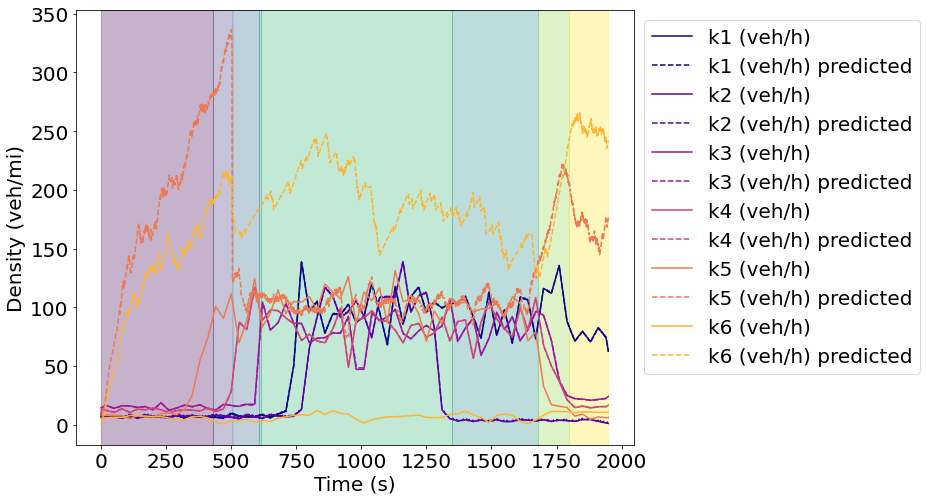

In [2589]:
plot_2densities(density_list_sumo,x_list)

In [2671]:
true_prob_list = []
for i in range(len(density_list_sumo)):
    m_i = mode_list[i]
    true_prob_list.append(mu_list[i][m_i])

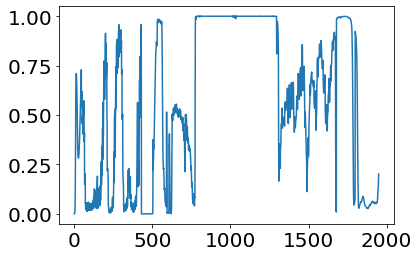

In [2674]:
plt.plot(list(range(T)), true_prob_list)

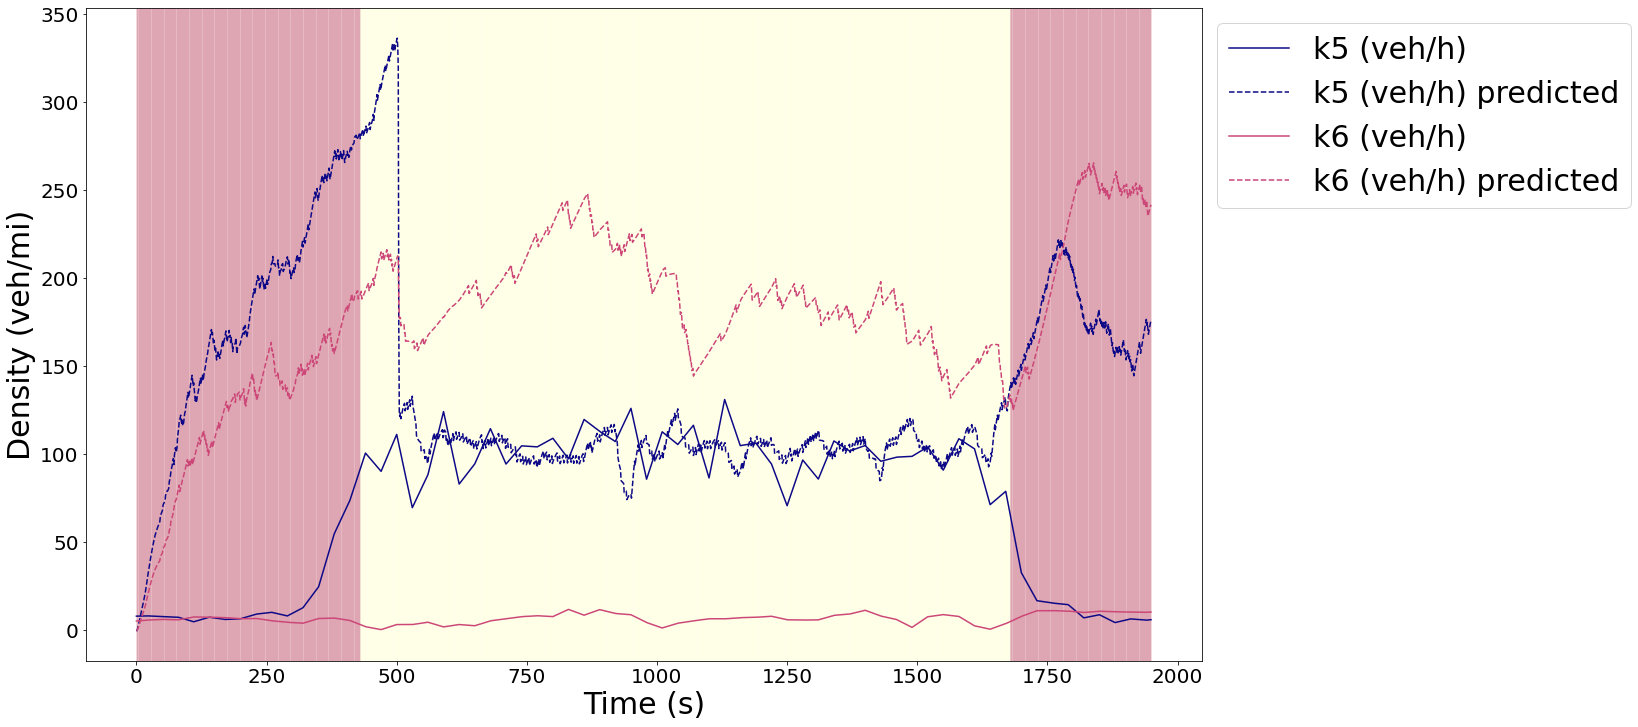

In [2605]:
obs_num_list = observability_score_mode(A_list, C, mode_list)
plot_2densities_mode( density_list_sumo,x_list, obs_num_list, vect)

In [ ]:
observability_list

In [2458]:
# Example data

values = np.array(all_comb)+1
observability_list_array = np.array(observability_list)
MAPE_list_array = np.array(MAPE_list)

# Get the indices that would sort the 'values' vector
sorted_indices = np.argsort(observability_list_array)

# Use the sorted indices to rearrange the vectors
sorted_values = values[sorted_indices][::-1]
sorted_vector1 = observability_list_array[sorted_indices][::-1]
sorted_vector2 = MAPE_list_array[sorted_indices][::-1]



In [ ]:
a = zip(sorted_values,sorted_vector1,sorted_vector2)

In [2459]:
for i in range(15):
    print(tuple(sorted_values[i]), sorted_vector1[i],sorted_vector2[i])

(1, 2, 5, 6) 5.818461538461539 17.9289
(1, 2, 4, 6) 5.588205128205127 41.6826
(1, 3, 5, 6) 5.586153846153846 27.2516
(1, 4, 5, 6) 5.5200000000000005 37.1496
(2, 3, 5, 6) 5.272820512820513 351.0031
(1, 3, 4, 6) 5.265128205128205 78.5845
(1, 2, 3, 6) 4.961538461538462 92.5173
(1, 2, 3, 5) 4.961538461538462 481.7696
(2, 3, 4, 6) 4.951794871794872 423.0577
(1, 2, 4, 5) 4.947692307692307 241.3734
(2, 4, 5, 6) 4.8933333333333335 28.6791
(1, 2, 3, 4) 4.6405128205128205 673.4892
(1, 3, 4, 5) 4.624615384615385 667.952
(3, 4, 5, 6) 4.622564102564103 303.7706
(2, 3, 4, 5) 4.311282051282052 1342.3943


In [ ]:
 np.array(all_comb)+1

In [ ]:
sorted_values

In [ ]:
sensor_loc

In [ ]:
print(mean)

In [2408]:
all_comb

[(0, 1, 2, 3),
 (0, 1, 2, 4),
 (0, 1, 2, 5),
 (0, 1, 3, 4),
 (0, 1, 3, 5),
 (0, 1, 4, 5),
 (0, 2, 3, 4),
 (0, 2, 3, 5),
 (0, 2, 4, 5),
 (0, 3, 4, 5),
 (1, 2, 3, 4),
 (1, 2, 3, 5),
 (1, 2, 4, 5),
 (1, 3, 4, 5),
 (2, 3, 4, 5)]

E:\Anaconda\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


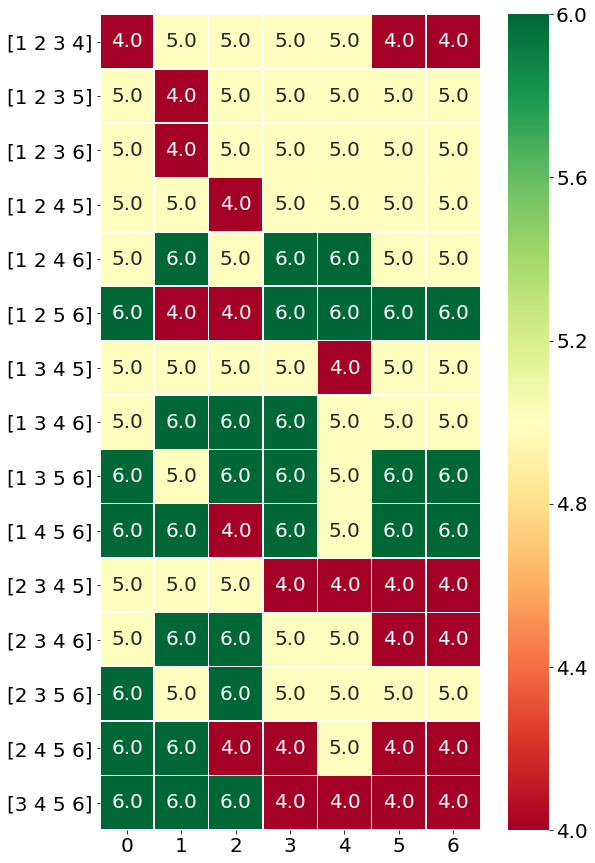

In [2416]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 15))
#     MAPE_by_mode_list.append(list(MAPE_by_mode))
#     observability_score_by_mode(A_list, C, mode_list)
#     observability_by_mode_list.append(observability_score_by_mode(A_list, C, mode_list))

row_labels = list(np.array(all_comb)+1)
col_labels = np.arange(len(A_list))

# Create a heatmap with annotations
sns.heatmap(observability_by_mode_list, annot=True, cmap="RdYlGn", fmt=".1f", linewidths=.5, square=True, yticklabels=row_labels, xticklabels=col_labels)

# Rotate y-axis tick labels to be horizontal
plt.yticks(rotation=0)

# Show the plot
plt.show()

In [2450]:
MAPE_by_mode_list_scaled = np.copy(MAPE_by_mode_list)
MAPE_by_mode_list_scaled[np.array(MAPE_by_mode_list)>3] = 3
MAPE_by_mode_list_scaled

array([[3.        , 3.        , 3.        , 3.        , 3.        ,
        3.        , 3.        ],
       [2.80349018, 3.        , 3.        , 3.        , 3.        ,
        2.61766545, 3.        ],
       [2.33733507, 0.93603813, 0.13615323, 0.14240988, 0.11252018,
        1.13631274, 2.96557405],
       [1.05434444, 3.        , 3.        , 2.76918493, 2.39540299,
        1.56764213, 2.5977716 ],
       [0.80720676, 0.32568843, 0.22037213, 0.1137924 , 0.09781937,
        0.8414667 , 1.37442677],
       [0.20841093, 0.24171627, 0.26135708, 0.17778557, 0.12552376,
        0.22416952, 0.23827235],
       [2.73780173, 3.        , 3.        , 3.        , 3.        ,
        3.        , 3.        ],
       [0.88281109, 0.33958311, 0.21654021, 0.35241449, 0.22963507,
        1.76528406, 3.        ],
       [0.1865114 , 0.2916077 , 0.2398152 , 0.43311566, 0.2272976 ,
        0.28146503, 0.38051449],
       [0.17744185, 0.27854098, 0.23087195, 1.0459522 , 0.22427527,
        0.25116743, 0.3

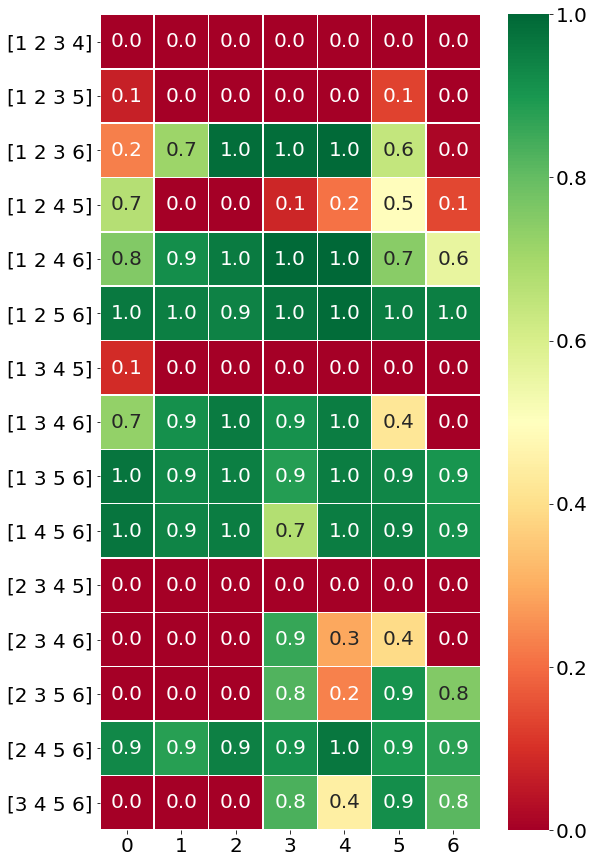

In [2451]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 15))
#     MAPE_by_mode_list.append(list(MAPE_by_mode))
#     observability_score_by_mode(A_list, C, mode_list)
#     observability_by_mode_list.append(observability_score_by_mode(A_list, C, mode_list))

row_labels = list(np.array(all_comb)+1)
col_labels = np.arange(len(A_list))

# Create a heatmap with annotations
sns.heatmap(global_min_max_scaling_2d_list(list(3-np.array(MAPE_by_mode_list_scaled))), annot=True, cmap="RdYlGn", fmt=".1f", linewidths=.5, square=True, yticklabels=row_labels, xticklabels=col_labels)

# Rotate y-axis tick labels to be horizontal
plt.yticks(rotation=0)

# Show the plot
plt.show()

In [2440]:
def global_min_max_scaling_2d_list(data_2d):
    # Flatten the 2D list to get all values
    flattened_data = [x for row in data_2d for x in row]

    # Compute global minimum and maximum
    global_min = min(flattened_data)
    global_max = max(flattened_data)

    # Min-Max scaling for each column using global min and max
    scaled_data_2d = [
        [(x - global_min) / (global_max - global_min) for x in row] for row in data_2d
    ]

    return scaled_data_2d


def global_z_score_scaling_2d_list(data_2d):
    # Flatten the 2D list to get all values
    flattened_data = [x for row in data_2d for x in row]

    # Compute global mean and standard deviation
    global_mean = np.mean(flattened_data)
    global_std = np.std(flattened_data)

    # Z-score scaling for each column using global mean and std
    scaled_data_2d = [
        [(x - global_mean) / global_std for x in row] for row in data_2d
    ]

    return scaled_data_2d

## MAPE_by_mode_list

In [ ]:
from collections import Counter

# Count occurrences
element_counts = Counter(mode_list)

# Print the counts
for element, count in element_counts.items():
    print(f"{element}: {count} times")

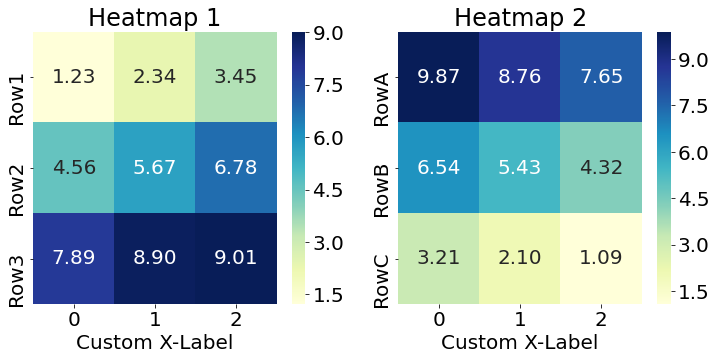

In [2377]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example data for Heatmap 1
data1 = [
    [1.23, 2.34, 3.45],
    [4.56, 5.67, 6.78],
    [7.89, 8.90, 9.01]
]

# Example row labels for Heatmap 1
row_labels1 = ['Row1', 'Row2', 'Row3']

# Example data for Heatmap 2
data2 = [
    [9.87, 8.76, 7.65],
    [6.54, 5.43, 4.32],
    [3.21, 2.10, 1.09]
]

# Example row labels for Heatmap 2
row_labels2 = ['RowA', 'RowB', 'RowC']

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figure size as needed

# Heatmap 1
sns.heatmap(data1, annot=True, fmt=".2f", cmap="YlGnBu", yticklabels=row_labels1, ax=axes[0])
axes[0].set_title('Heatmap 1')

# Heatmap 2
sns.heatmap(data2, annot=True, fmt=".2f", cmap="YlGnBu", yticklabels=row_labels2, ax=axes[1])
axes[1].set_title('Heatmap 2')

# Set common x-label
for ax in axes:
    ax.set_xlabel('Custom X-Label')

plt.show()

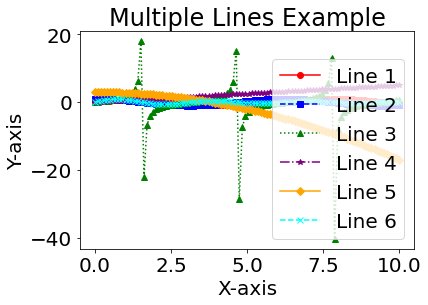

In [2461]:
# Generate sample data for 6 lines
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x)
y4 = 0.5 * x
y5 = -0.2 * x**2 + 3
y6 = np.exp(-0.2 * x) * np.sin(2 * x)

# Plot the lines with different styles
plt.plot(x, y1, color='red', linestyle='-', marker='o', label='Line 1')
plt.plot(x, y2, color='blue', linestyle='--', marker='s', label='Line 2')
plt.plot(x, y3, color='green', linestyle=':', marker='^', label='Line 3')
plt.plot(x, y4, color='purple', linestyle='-.', marker='*', label='Line 4')
plt.plot(x, y5, color='orange', linestyle='-', marker='D', label='Line 5')
plt.plot(x, y6, color='cyan', linestyle='--', marker='x', label='Line 6')

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Multiple Lines Example')
plt.legend()

# Show the plot
plt.show()

In [2663]:

def plot_density_sumo(density_list, mode_list):
    import matplotlib.pyplot as plt
    plt.rc('font', size=30)
    T = len(density_list)
    t_list = list(range(T))
    
#     for j in range(n):
#         k_list = [i[j][0] for i in density_list]
#         plt.plot(t_list, k_list, label ="k" +str(j)+"(veh/mi)")
    
    # Create the plot

    fig, ax = plt.subplots(figsize=(20, 12)) 
    
    marker_list=['o','s','^', '*',"D","x"]
    color_list = ['red','green','blue','purple','orange','cyan']
    linestyle_list = ['-','--',':','-.','-','--']
    
    for j in range(n):
        k_list = [i[j][0] for i in density_list]   
        ax.plot(t_list, k_list,color=color_list[j],linestyle=linestyle_list[j], linewidth=2.5, label='link '+str(j+1))
    

#     # Fill the background between x=0 and x=1 with red
#     ax.axvspan(0, 1, alpha=0.1, color='red')

#     # Fill the background between x=1 and x=3 with blue
#     ax.axvspan(1, 3, alpha=0.3, color='blue')

    # Define a colormap with different colors for each index
#     cmap = plt.cm.get_cmap('da', max(mode_list)+1)
    
    colors = ['tab:gray', 'tab:olive', 'tab:cyan', 'tab:pink', 'tab:blue', 'tab:orange', 'tab:green']
    start_index = 0
    counter = 0
    for end_index in range(1, T):
        if mode_list[end_index]!=mode_list[start_index]:
            if start_index != 1348:
                ax.axvspan(start_index, end_index-1, alpha=0.4, color=colors[mode_list[start_index]], label=f'mode {mode_list[start_index]+1}')
            else:
                ax.axvspan(start_index, end_index-1, alpha=0.4, color=colors[mode_list[start_index]])

            start_index = end_index
            counter+=1
    
    ax.axvspan(start_index, end_index, alpha=0.4, color=colors[mode_list[start_index]], label=f'mode {mode_list[start_index]+1}')
    
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    #plt.legend(loc="upper left")
    plt.xlabel('Time (s)')
    plt.ylabel('Density (veh/km)')
    plt.xticks(fontsize=32)
    plt.yticks(fontsize=32)
    plt.show()
    

In [2664]:
enumerate(mode_list)

In [2665]:
m_i = -1
for i,m_ in enumerate(mode_list):
    if m_!=m_i:
        m_i = m_
        print(i)

0
430
505
607
616
1348
1679
1799


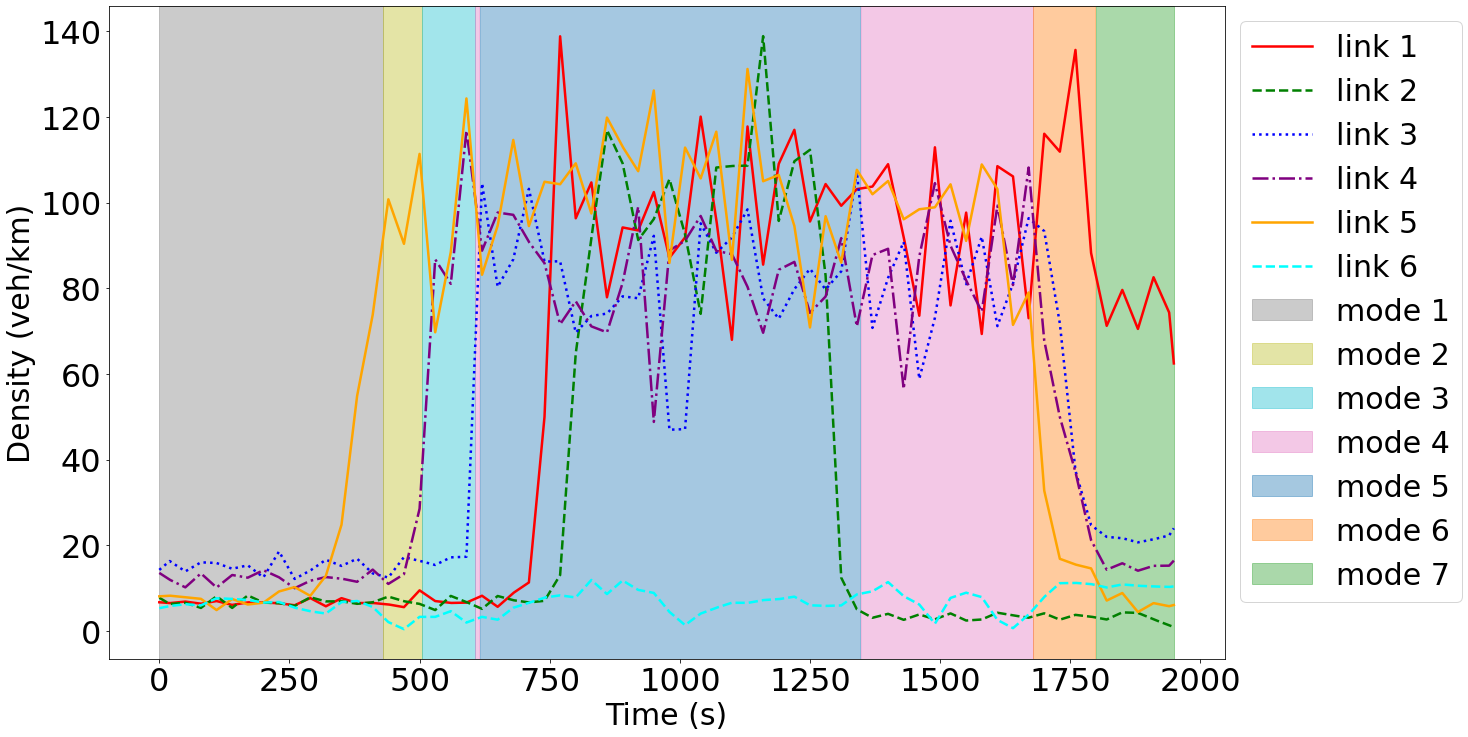

In [2666]:

plot_density_sumo(density_list_sumo, mode_list)

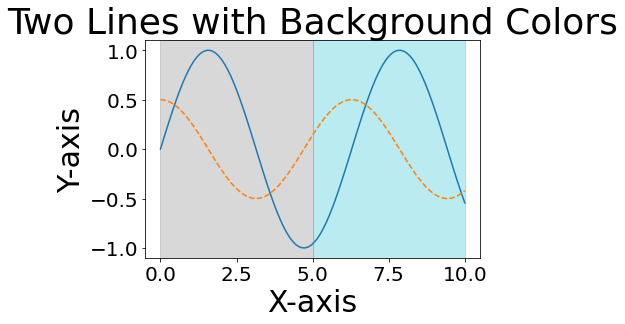

In [2668]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Generate sample data for 2 lines
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = 0.5 * np.cos(x)

# Plot the lines without markers
plt.plot(x, y1, color='tab:blue', linestyle='-', label='Line 1')
plt.plot(x, y2, color='tab:orange', linestyle='--', label='Line 2')

# Add background colors
background_colors = ['tab:gray', 'tab:cyan']
background_limits = [(i * 5, (i + 1) * 5) for i in range(2)]

for limit, color in zip(background_limits, background_colors):
    plt.axvspan(limit[0], limit[1], alpha=0.3, color=color, label=f'Background {color}')

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Two Lines with Background Colors')


# Show the plot
plt.show()

In [2734]:
print(A_list[1])

[[ 0.85        0.          0.          0.          0.          0.        ]
 [ 0.          0.9         0.          0.          0.          0.        ]
 [ 0.15        0.1         0.85        0.          0.          0.        ]
 [ 0.          0.          0.15        1.          0.04166667  0.        ]
 [ 0.          0.          0.          0.          0.975       0.        ]
 [ 0.          0.          0.          0.         -0.01666667  1.        ]]


In [2735]:
u_list[1]

array([[ 0.   ],
       [ 0.   ],
       [ 0.   ],
       [-5.625],
       [ 3.375],
       [ 2.25 ]])

In [2718]:
print(A_list[6])

[[1.    0.1   0.025 0.    0.    0.   ]
 [0.    0.9   0.    0.    0.    0.   ]
 [0.    0.    0.975 0.    0.    0.   ]
 [0.    0.    0.    0.85  0.    0.   ]
 [0.    0.    0.    0.09  1.    0.   ]
 [0.    0.    0.    0.06  0.    1.   ]]


In [2719]:
u_list[6]

array([[-3.375     ],
       [ 0.        ],
       [ 0.48214286],
       [ 2.89285714],
       [ 0.        ],
       [ 0.        ]])

In [2758]:
FD1.kj *FD1.w /3600*5/0.6

5.625

In [2747]:
FD1.C

3471.428571428571